## Import necessary libraries

In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get the data

In [145]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa
10,4.9,3.1,1.5,0.1,Iris-setosa


In [146]:
# Samples from each species
data["type"].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: type, dtype: int64

## Data Visualization

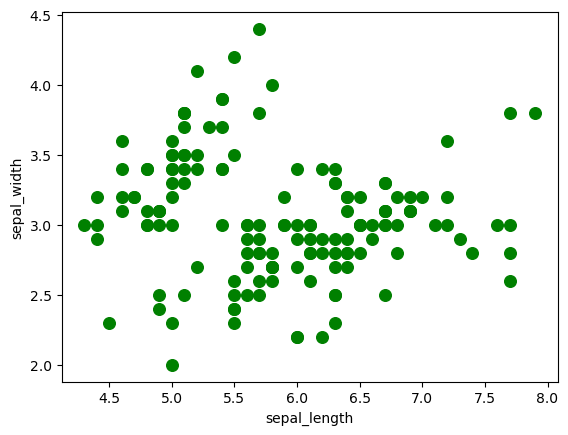

In [147]:
#To change color and size, add the following:
data.plot(kind="scatter", x="sepal_length", y="sepal_width",color="green",s=70 )
plt.show()

/Users/angelicadeigratiapyngrope/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


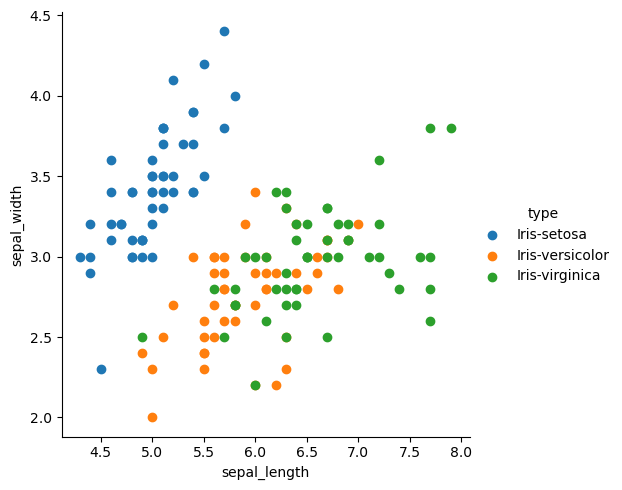

In [148]:
# Modify the graph above by assigning each species an individual color.
sns.FacetGrid(data, hue="type", size=5) \
   .map(plt.scatter, "sepal_length", "sepal_width") \
   .add_legend()
plt.show()

## Visualizing the data using pandas’ andrew curves :
Andrews curves have the functional form:

f(t) = x_1/sqrt(2) + x_2 sin(t) + x_3 cos(t) +

x_4 sin(2t) + x_5 cos(2t) + …

Where x coefficients correspond to the values of each dimension and t is linearly spaced between -pi and +pi. Each row of the frame then corresponds to a single curve.

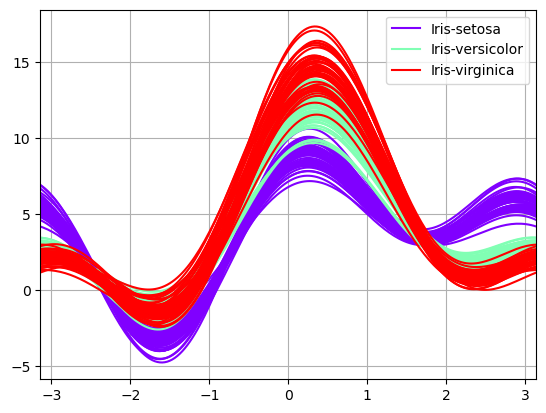

In [149]:
from pandas.plotting import andrews_curves

andrews_curves(data, 'type', colormap='rainbow')
plt.show()

## Node Class

In [150]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

## Tree Class

In [151]:
class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        #if mode=="entropy":
         #   gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        #else:
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))        
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    #def gini_index(self, y):
        #''' function to compute gini index '''
        
        #class_labels = np.unique(y)
        #gini = 0
        #for cls in class_labels:
            #p_cls = len(y[y == cls]) / len(y)
            #gini += p_cls**2
    #return 1 - gini

    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

## Train Test Split

In [152]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

## Fit the model

In [153]:
classifier = DecisionTreeClassifier(min_samples_split=3, max_depth=3)
classifier.fit(X_train,Y_train)
classifier.print_tree()

X_2 <= 1.9 ? 0.9264046681474138
 left:Iris-setosa
 right:X_3 <= 1.5 ? 0.7694993941591152
  left:X_2 <= 4.9 ? 0.17556502585750278
    left:Iris-versicolor
    right:Iris-virginica
  right:X_2 <= 5.0 ? 0.1228956258058704
    left:X_1 <= 2.8 ? 0.46691718668869925
        left:Iris-virginica
        right:Iris-versicolor
    right:Iris-virginica


## Test the model

In [155]:
Y_pred = classifier.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333

In [156]:
def accuracy(Y_test,Y_pred,normalize=True):
    accuracy=[]
    for i in range(len(Y_pred)):
        if Y_pred[i]==Y_test[i]:
            accuracy.append(1)
        else:
            accuracy.append(0)
    if normalize==True:
        return np.mean(accuracy)
    if normalize==False:
        return sum(accuracy)
x = accuracy(Y_test, Y_pred)    
print("Accuracy : ",x)   

Accuracy :  0.9333333333333333


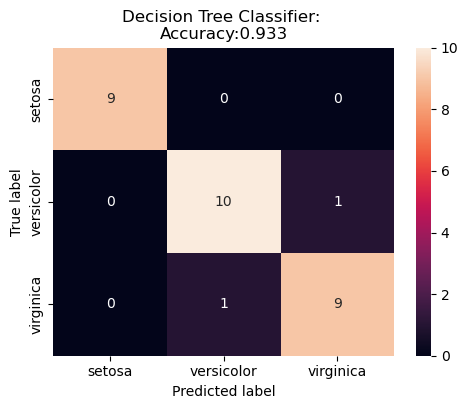

<AxesSubplot:>

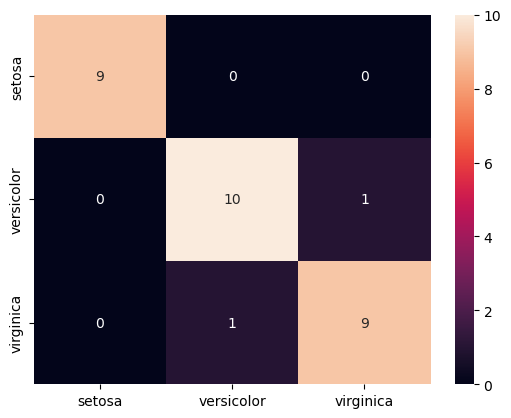

In [157]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, Y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['setosa','versicolor','virginica'], 
                     columns = ['setosa','versicolor','virginica'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Decision Tree Classifier: \nAccuracy:{0:.3f}'.format(accuracy(Y_test, Y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
sns.heatmap(cm_df,annot=True,fmt="d")

## Results
We have 3 different classifications our data can be placed into. This confusion matrix is telling us that the model predicted:

Setosa (type 1) => Samples: 9, Correctly classified: 9
Versicolor (type 2) => Samples: 10, Correctly classified: 10. 1 sample was incorrectly classified as type 3.
Virginica (type 3) => Samples: 9, Correctly classified: 9. 1sample was incorrectly classified as type 2.

## Comparing to sklearn

In [218]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [219]:
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'type']
data = pd.read_csv("iris.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,type
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
6,5.4,3.9,1.7,0.4,Iris-setosa
7,4.6,3.4,1.4,0.3,Iris-setosa
8,5.0,3.4,1.5,0.2,Iris-setosa
9,4.4,2.9,1.4,0.2,Iris-setosa
10,4.9,3.1,1.5,0.1,Iris-setosa


In [220]:
# get all categories of a category type column
# change to category dtype
data["type"] = data["type"].astype("category")
# display the dataframe
print(data)
data["type"].cat.categories

     sepal_length  sepal_width  petal_length  petal_width            type
1             5.1          3.5           1.4          0.2     Iris-setosa
2             4.9          3.0           1.4          0.2     Iris-setosa
3             4.7          3.2           1.3          0.2     Iris-setosa
4             4.6          3.1           1.5          0.2     Iris-setosa
5             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
146           6.7          3.0           5.2          2.3  Iris-virginica
147           6.3          2.5           5.0          1.9  Iris-virginica
148           6.5          3.0           5.2          2.0  Iris-virginica
149           6.2          3.4           5.4          2.3  Iris-virginica
150           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]


Index(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype='object')

In [221]:
data.shape

(150, 5)

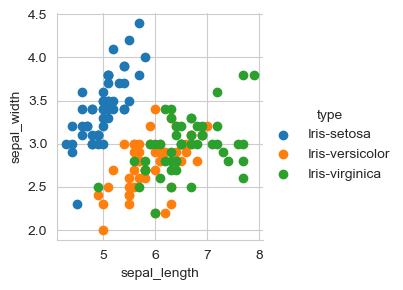

In [222]:
sns.set_style('whitegrid')
sns.FacetGrid(data, hue = 'type') \
    .map(plt.scatter, 'sepal_length', 'sepal_width') \
    .add_legend()
plt.show()

In [223]:
# import the function
from sklearn.model_selection import train_test_split

# Split our data into the training sets and the testing sets
# Each set has a pair of X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [224]:
## Import and create the model
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

# Train our model with our training data.
clf.fit(X_train, y_train)

DecisionTreeClassifier()

|--- petal width (cm) <= 0.80
|   |--- class: setosa
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.65
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: versicolor
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- class: virginica
|   |--- petal width (cm) >  1.65
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- class: virginica
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: virginica



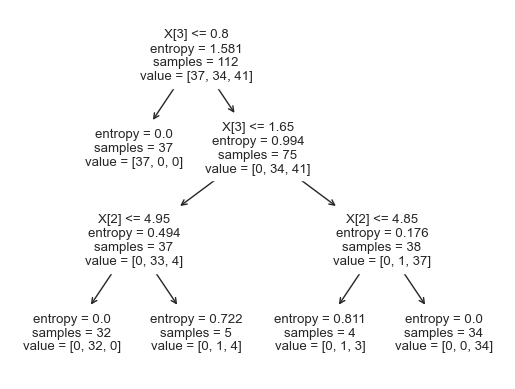

In [225]:
from sklearn.tree import plot_tree
from sklearn.tree import export_text
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, min_samples_split = 3)

# Train our model with our training data.
clf.fit(X_train, yss_train)
plot_tree(clf)
r = export_text(clf, feature_names=iris['feature_names'])
print(r)

|--- petal width (cm) <= 0.80
|   |--- class: setosa
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.65
|   |   |--- petal length (cm) <= 4.95
|   |   |   |--- class: versicolor
|   |   |--- petal length (cm) >  4.95
|   |   |   |--- petal width (cm) <= 1.55
|   |   |   |   |--- class: virginica
|   |   |   |--- petal width (cm) >  1.55
|   |   |   |   |--- sepal length (cm) <= 6.60
|   |   |   |   |   |--- class: versicolor
|   |   |   |   |--- sepal length (cm) >  6.60
|   |   |   |   |   |--- class: virginica
|   |--- petal width (cm) >  1.65
|   |   |--- petal length (cm) <= 4.85
|   |   |   |--- sepal width (cm) <= 3.10
|   |   |   |   |--- class: virginica
|   |   |   |--- sepal width (cm) >  3.10
|   |   |   |   |--- class: versicolor
|   |   |--- petal length (cm) >  4.85
|   |   |   |--- class: virginica



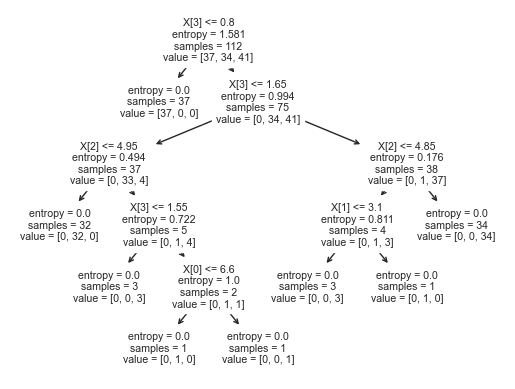

In [230]:
from sklearn.tree import plot_tree
from sklearn.tree import export_text
clf = DecisionTreeClassifier(criterion = 'entropy')

# Train our model with our training data.
clf.fit(X_train, y_train)
plot_tree(clf)
r = export_text(clf, feature_names=iris['feature_names'])
print(r)

Let's analyze the first node.

X[2] <= 0.8
gini = 1.581
samples = 112
What is this telling us? Several things:

X[2] <= 0.8: Our model seems to have decided that the first feature it wants to make a decision on is number 3 (remember python lists start at index 0). This feature is petal length (cm). It also chose 2.6 as the dividing value.
entropy: The impurity of the node.
samples: The amount of training samples that went through this node. In this case all of them since it's the first node.
Looking at the left child node of this first node we find a leaf. Leaves are end nodes, nodes that do not have children. When a sample reaches a leaf node it is already classified. In our case, looking at the values, we can see that 37 training values landed on this end node and we're all classified as type 1 (setosa).

The right child on the the other hand makes another split and continues the tree, making more decisions down the road until classifing the samples.

Now, consider the leaf nodes (terminal nodes) of the tree with and without the max_depth parameter. You will notice that the entropy all the terminal nodes are zero in the tree without the max_depth parameter and non zero in three with that parameter. This is because when the parameter is not mentioned, the split recursively takes place till the terminal node has an entropy of zero.

In [226]:
Y_pred = clf.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9736842105263158

In [227]:
# Call the .predict() function of the model and feed in the testing data
y_pred   = clf.predict(X_test) #making precdictions
print(classification_report(y_test,   y_pred)) #Summary of the predictions made by the   classifier
print(confusion_matrix(y_test, y_pred)) #to evaluate the quality of the output
print('accuracy   is',accuracy_score(y_pred,y_test)) #Accuracy   score

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38

[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]
accuracy   is 0.9736842105263158






1. Precision – Accuracy of positive predictions.

2. Recall – Fraction of positives that were correctly identified.

3. F1 score – What percent of positive predictions were correct?

4. macro avg – averaging the unweighted mean per label

5. weighted avg – averaging the support-weighted mean per label


In [228]:
Y_pred = clf.predict(X_test) 
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9736842105263158

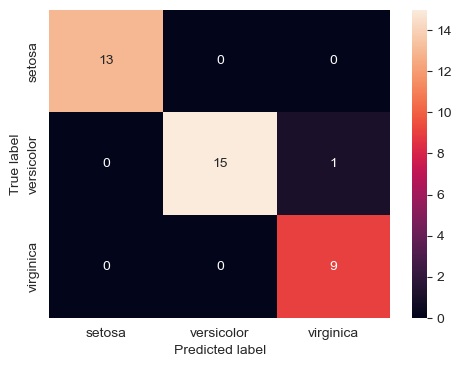

In [229]:
cm  = confusion_matrix(y_test, y_pred) #Transform to dataframe
cm_df = pd.DataFrame(cm,index = ['setosa','versicolor','virginica'], columns = ['setosa','versicolor','virginica'])
plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df,   annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()